<a href="https://colab.research.google.com/github/gmshashank/Geometric_Deep_Learning/blob/main/pointnet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import torch

In [2]:
def transform_image_point_cloud(input_image):
  """
  returns indices of pixels of image that are higher than 127
  """
  input_image_array=np.asarray(input_image)
  indices=np.argwhere(input_image_array>127)
  return indices.astype(np.float32)

In [3]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [4]:
dataset=MNIST(root="./data",train=True,download=True)
len_points=[]

for idx in range(len(dataset)):
  image,label=dataset[idx]
  image_point_cloud=transform_image_point_cloud(image)
  len_points.append(len(image_point_cloud))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Text(0.5, 1.0, 'Histogram of amount of points per numer in MNIST')

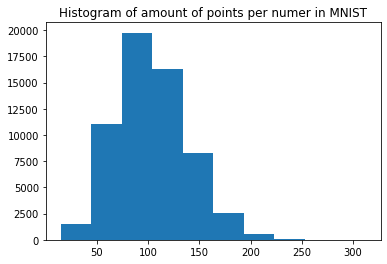

In [5]:
h=plt.hist(len_points)
plt.title("Histogram of amount of points per numer in MNIST")

In [7]:
min(len_points),max(len_points)

(15, 312)

In [9]:
from numpy.lib.function_base import average
average(len_points)

103.69051666666667

In [17]:
from torch.utils.data import Dataset

class MNIST3D(Dataset):

  NUM_CLASSIFICATION_CLASSES=10
  POINT_DIMENSION=3

  def __init__(self,dataset,num_points):
    self.dataset=dataset
    self.number_of_points=num_points

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    image,label=dataset[idx]
    point_cloud=transform_image_point_cloud(image)

    if self.number_of_points-point_cloud.shape[0]>0:
      # Duplicate the points (points >200)
      sampling_indices=np.random.choice(point_cloud.shape[0],self.number_of_points-point_cloud.shape[0])
      new_sampled_points=point_cloud[sampling_indices,:]
      point_cloud=np.concatenate((point_cloud,new_sampled_points),axis=0)
    else:
      # sample points
      sampling_indices=np.random.choice(point_cloud.shape[0],self.number_of_points)
      point_cloud=point_cloud[sampling_indices,:]
    
    point_cloud=point_cloud.astype(np.float32)

    #adding z channel
    noise=np.random.normal(0,0.05,len(point_cloud))
    noise=np.expand_dims(noise,1)
    point_cloud=np.hstack([point_cloud,noise]).astype(np.float32)
    point_cloud=torch.tensor(point_cloud)

    return point_cloud,label

In [14]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [22]:
# Hyperparameters
BATCH_SIZE=128
NUM_POINTS=200
LR=0.001

In [21]:
# creating the new 3D MNIST dataset
train_dataset=MNIST(root="./data/MNIST",download=True,train=True)
test_dataset=MNIST(root="./data/MNIST",download=True,train=False)
dataset=torch.utils.data.ConcatDataset([train_dataset,test_dataset])

dataset_3D=MNIST3D(dataset,NUM_POINTS)
len_data=len(dataset_3D)
train_dataset,val_dataset,test_dataset=random_split(dataset_3D,[round(0.8*len_data),round(0.1*len_data),round(0.1*len_data)],generator=torch.Generator().manual_seed(1))

train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [27]:
sample_idx=5

Text(0.5, 0.92, 'label: 4')

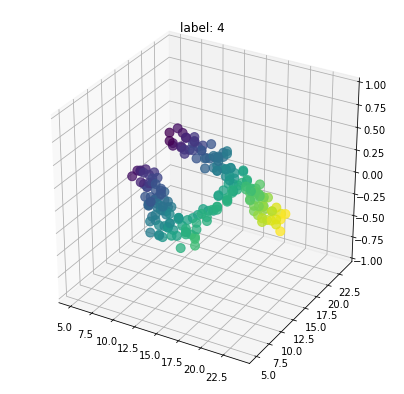

In [28]:
# visualize the 3d numbers
point_cloud=train_dataset[sample_idx][0].numpy()
label=train_dataset[sample_idx][1]
fig=plt.figure(figsize=[7,7])
ax=plt.axes(projection="3d")
sc=ax.scatter(point_cloud[:,0],point_cloud[:,1],point_cloud[:,2],c=point_cloud[:,0],s=80,marker="o",cmap="viridis",alpha=0.75)
ax.set_zlim3d(-1,1)
plt.title(f"label: {label}")